In [1]:
import os
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
%matplotlib inline

## Set paths

In [2]:
wd = os.path.abspath("../data/Excel")

features_name = "PGA1_Cognición_RAW SCORE_18.11.2024.xlsx"
diagnosis_name = "FIS2021_PGA1_CLASIFICACIÓN_PATOLOGÍA_VACULAR_411PGA1_corregido.xlsx"
apoe_name = "Datos_Cognicion_PGA.xlsx"

In [3]:
def residualize_with_centering(df, target_cols, predictor_col, ref_cols=None):
    if ref_cols is not None:
        tmp = df.clone()
        result_df = tmp.select(ref_cols)
    else:
        result_df = pl.DataFrame()
    
    for target_col in target_cols:
        mask = df.select([
            pl.col(target_col).is_not_null() & 
            pl.col(predictor_col).is_not_null()
        ]).to_series()
        
        df_clean = df.filter(mask)
        
        X = df_clean[predictor_col].to_numpy().reshape(-1, 1)
        y = df_clean[target_col].to_numpy()
        
        model = LinearRegression()
        model.fit(X, y)
        residuals = y - model.predict(X)
        
        # Add back the original mean
        original_mean = df[target_col].mean()
        residuals_centered = residuals + original_mean
        
        full_residuals = np.full(len(df), np.nan)
        full_residuals[mask.to_numpy()] = residuals_centered
        
        result_df = result_df.with_columns(
            pl.Series(f'{target_col}_yoe_corrected', full_residuals)
        )
    
    return result_df

### Load data, get rid of null values coded as 9999 or 8888

In [4]:
df_features = pl.read_excel(os.path.join(wd, features_name), has_header=True).select(
    pl.all().map_elements(lambda x: None if x == 9999 or x =="9999" else x)
)
df_features = df_features.select(
    pl.all().map_elements(lambda x: None if x == 8888 or x =="8888" else x)
)

df_diagnosis = pl.read_excel(os.path.join(wd, diagnosis_name), has_header=True)
df_diagnosis = df_diagnosis.select(
    pl.all().map_elements(lambda x: None if x == 9999 or x =="9999" else x)
)
df_diagnosis = df_diagnosis.select(
    pl.all().map_elements(lambda x: None if x == 8888 or x =="8888" else x)
)

df_apoe = pl.read_excel(os.path.join(wd, apoe_name), has_header=True)
df_apoe = df_apoe.select(
    pl.all().map_elements(lambda x: None if x == 9999 or x =="9999" else x)
)
df_apoe = df_apoe.select(
    pl.all().map_elements(lambda x: None if x == 8888 or x =="8888" else x)
)
df_apoe = df_apoe.select(
    pl.all().map_elements(lambda x: None if x == 999 or x =="999" else x)
)

In [5]:
print(df_features.head(3))
print(df_diagnosis.head(3))
print(df_apoe.head(3))

shape: (3, 43)
┌──────────┬─────────┬─────┬────────┬───┬──────────────┬──────────────┬──────────────┬─────────────┐
│ cmp_code ┆ Project ┆ Age ┆ Sex    ┆ … ┆ BostonNaming ┆ JLOTotal_PGA ┆ T15OBJV1_PGA ┆ NeoformsTes │
│ ---      ┆ ---     ┆ --- ┆ ---    ┆   ┆ _PGA1        ┆ 1            ┆ 1            ┆ t15obj_PGA1 │
│ str      ┆ str     ┆ i64 ┆ str    ┆   ┆ ---          ┆ ---          ┆ ---          ┆ ---         │
│          ┆         ┆     ┆        ┆   ┆ i64          ┆ i64          ┆ i64          ┆ i64         │
╞══════════╪═════════╪═════╪════════╪═══╪══════════════╪══════════════╪══════════════╪═════════════╡
│ 000181   ┆ PGA V1  ┆ 57  ┆ Female ┆ … ┆ 33           ┆ 17           ┆ 7            ┆ 6           │
│ 000080   ┆ PGA V1  ┆ 63  ┆ Male   ┆ … ┆ 54           ┆ 23           ┆ 13           ┆ 3           │
│ 000179   ┆ PGA V1  ┆ 64  ┆ Female ┆ … ┆ 46           ┆ 14           ┆ 8            ┆ 3           │
└──────────┴─────────┴─────┴────────┴───┴──────────────┴──────────────┴─────

## Get the features of the participants belonging to PGA only.

In [6]:
df_features_pga = df_features.filter(pl.col("Project") == "PGA V1").drop("Project")

df_diagnosis_pga = df_diagnosis.filter(pl.col("Project") == 1).drop("Project")

df_apoe = df_apoe.filter(pl.col("Project") == "PGA V1").drop("Project")
df_apoe = df_apoe.filter(pl.col("APOE_Genotype") != "999")
df_apoe = df_apoe.select(["cmp_code", "APOE_Genotype"])

df_diagnosis_pga = df_diagnosis_pga.join(df_apoe, left_on="cmp_code",
                                         right_on="cmp_code", how="inner")

### Select the features that have "total" in their name. This first feature set is about total scores of tests

In [7]:
total_features = ["cmp_code", "Age"] + [f for f in df_features.columns if "TOTAL" in f or "total" in f or "Total" in f]
df_features_total_pga = df_features_pga.select(total_features)

# Reorder the columns
df_features_total_pga = df_features_total_pga.sort("cmp_code")

print(df_features_total_pga.head(3))
print("Number of participants in PGA with total features:", df_features_total_pga.height)

shape: (3, 13)
┌──────────┬─────┬────────────┬────────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ cmp_code ┆ Age ┆ MMSE_total ┆ TAM_total_ ┆ … ┆ STROOP_Col ┆ STROOP_Wor ┆ ZooBADS_To ┆ JLOTotal_P │
│ ---      ┆ --- ┆ _PGA1      ┆ PGA1       ┆   ┆ or_total_P ┆ dColor_tot ┆ tal_PGA1   ┆ GA1        │
│ str      ┆ i64 ┆ ---        ┆ ---        ┆   ┆ GA1        ┆ al_PGA1    ┆ ---        ┆ ---        │
│          ┆     ┆ i64        ┆ i64        ┆   ┆ ---        ┆ ---        ┆ i64        ┆ i64        │
│          ┆     ┆            ┆            ┆   ┆ i64        ┆ i64        ┆            ┆            │
╞══════════╪═════╪════════════╪════════════╪═══╪════════════╪════════════╪════════════╪════════════╡
│ 000003   ┆ 57  ┆ 28         ┆ 41         ┆ … ┆ 52         ┆ 45         ┆ 2          ┆ 20         │
│ 000007   ┆ 50  ┆ 29         ┆ 49         ┆ … ┆ 79         ┆ 50         ┆ 11         ┆ 27         │
│ 000008   ┆ 62  ┆ 28         ┆ 49         ┆ … ┆ 80         ┆ 41         ┆ 9

## Extended feature set that does not include only total scores
### We only include the features that passed bonferroni correction in the features vs age analysis for the control group.

In [8]:
# Stuff that we do not need
to_drop = ["BirthDate", "NPSDATE", "Educ_years", "Sex"]
to_drop += ["tam_frercl_pga1", "neoformstest15obj_pga1", "tam_ttlscr_pga1", "tam_total_pga1",
           "jlototal_pga1", "bskdly_ttlrsc_pga1", "rocf_copy_pga1", "zoobads_total_pga1",
           "digit_forw_span_pga1", "stroop_interf_pga1", "letternumber_total_pga1",
           "digit_forw_total_pga1", "tam_cuercl_pga1"]
to_drop = [col.lower() for col in to_drop]

df_features_pga = df_features_pga.rename(
    {col: col.lower() for col in df_features_pga.columns}
)

df_features_all = df_features_pga.drop(*to_drop)

df_features_all = df_features_all.select(
    pl.all().map_elements(lambda x: None if x == 8888 or x =="8888" else x)
)
df_features_all = df_features_all.select(
    pl.all().map_elements(lambda x: None if x == 9999 or x =="9999" else x)
)

In [9]:
df_diagnosis_pga = df_diagnosis_pga.sort("cmp_code")
df_diagnosis_pga["APOE_Genotype"].value_counts()

APOE_Genotype,count
str,u32
"""3/2""",31
"""3/4""",99
"""4/4""",5
"""3/3""",272


### How many APOE4 carrier homozygotes do we have in the dataset?

In [10]:
df_diagnosis_pga.filter(pl.col("APOE_Genotype") == "4/4")

cmp_code,LCR,RM_OK,EXCLU_MCI,BirthDate,Age,Sex,DX_SYNDR_PGA1,DX_SYNDR_COGIMP_PGA1,EXCL_PATHOL_LCR,EXCL_PATOL_VASC,EXCL_PATOL_VASC_CORREGIDO,RM_ARWMC_FAZEKAS,MICROBLEEDS_PGA1,PresenciadeMICROSANGRADOS_PGA2,NÚMEROdemicrosangrados_PGA2,LOCALIZACIÓNdemicrosangrados_PGA2,ESTUDIO_VALIDO_PGA2,NotasPetición_PGA2,APOE_Genotype
str,i64,i64,i64,date,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,str,str,str,str
"""000198""",1,1,0,1946-11-08,66,0,3,0,2,0,0,1,0,"""NO""",null,null,null,"""Vena oftalmica izquierda dilat…","""4/4"""
"""000200""",1,1,0,1949-05-09,62,1,0,0,1,0,0,1,0,"""NO""",null,null,"""SI""",null,"""4/4"""
"""000255""",0,null,0,1956-02-12,55,0,3,0,null,0,0,0,null,null,null,null,null,null,"""4/4"""
"""000399""",0,1,1,1953-11-08,58,0,1,1,null,0,0,0,0,"""NO""",null,null,"""SI""",null,"""4/4"""
"""000526""",0,1,0,1957-11-11,54,0,3,0,null,0,0,1,0,"""NO""",null,null,"""SI""",null,"""4/4"""


## Now prepare the grouping

In [11]:
cu_amyloid_neg_vasc_neg = df_diagnosis_pga.filter(
    (pl.col("DX_SYNDR_COGIMP_PGA1") == 0) & # Participant is cognitively normal
    (pl.col("EXCL_PATHOL_LCR") == 0) & # No Amyloid alteration
    (pl.col("EXCL_PATOL_VASC_CORREGIDO") == 0) # No vascular pathology
).with_columns(
    pl.lit("cn").alias("group")
)

cu_amyloid_pos_vasc_neg = df_diagnosis_pga.filter(
    (pl.col("DX_SYNDR_COGIMP_PGA1") == 0) & # Participant is cognitively normal
    (pl.col("EXCL_PATHOL_LCR") == 1) & # Amyloid alteration
    (pl.col("EXCL_PATOL_VASC_CORREGIDO") == 0) # No filtering for vascular pathology
).with_columns(
    pl.lit("cu_amyloid_pos_vasc_neg").alias("group")
)

cu_amyloid_neg_vasc_pos = df_diagnosis_pga.filter(
    (pl.col("DX_SYNDR_COGIMP_PGA1") == 0) & # Participant is cognitively normal
    (pl.col("EXCL_PATHOL_LCR") == 0) & # Amyloid alteration
    (pl.col("EXCL_PATOL_VASC_CORREGIDO") == 1) # Vascular pathology
).with_columns(
    pl.lit("cu_amyloid_neg_vasc_pos").alias("group")
)

# ci_all = df_diagnosis_pga.filter(
#     (pl.col("DX_SYNDR_COGIMP_PGA1") == 1) & # Participant has mild cognitive impairment
#     (pl.col("LCR") == 1) & # Participant does have CSF data
#     (pl.col("EXCL_PATOL_VASC_CORREGIDO") == 0) # No vascular pathology
# ).with_columns(
#     pl.lit("ci").alias("group")
# )

df_diagnosis_pga_subgrouped = pl.concat([cu_amyloid_neg_vasc_neg,
                                        cu_amyloid_pos_vasc_neg,
                                        cu_amyloid_neg_vasc_pos]).sort("cmp_code")
df_diagnosis_pga_subgrouped.head(3)

cmp_code,LCR,RM_OK,EXCLU_MCI,BirthDate,Age,Sex,DX_SYNDR_PGA1,DX_SYNDR_COGIMP_PGA1,EXCL_PATHOL_LCR,EXCL_PATOL_VASC,EXCL_PATOL_VASC_CORREGIDO,RM_ARWMC_FAZEKAS,MICROBLEEDS_PGA1,PresenciadeMICROSANGRADOS_PGA2,NÚMEROdemicrosangrados_PGA2,LOCALIZACIÓNdemicrosangrados_PGA2,ESTUDIO_VALIDO_PGA2,NotasPetición_PGA2,APOE_Genotype,group
str,i64,i64,i64,date,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,str,str,str,str,str
"""000003""",1,null,0,1953-08-03,57,0,0,0,0,0,0,0,0,"""NO""",null,null,null,null,"""3/3""","""cn"""
"""000009""",1,1,0,1957-03-07,54,1,3,0,0,0,0,0,0,"""NO""",null,null,null,null,"""3/3""","""cn"""
"""000013""",1,1,0,1957-09-02,54,1,0,0,0,0,0,0,0,"""NO""",null,null,"""SI""","""SWI movida.""","""3/2""","""cn"""


In [12]:
import numpy as np

## First clinical subgrouping

In [13]:
clinical_subgrouped = df_diagnosis_pga_subgrouped.select(["group"])

# One hot encode the group column
clinical_subgrouped = clinical_subgrouped.to_dummies()
clinical_subgrouped = clinical_subgrouped.rename({"group_cn": "cn"})
renaming = {old_name: old_name.replace("group_", "") for old_name in clinical_subgrouped.columns}
clinical_subgrouped = clinical_subgrouped.rename(renaming)

clinical_subgrouped.sum()
# Check which row sums to 0 horizontally, get its index
if (clinical_subgrouped.to_numpy().sum(axis=1) == 0).any():
    idx = np.where(clinical_subgrouped.to_numpy().sum(axis=1) == 0)[0][0]
    print(f"Row {idx} sums to 0 horizontally..")
    print("Let's find its 'cmp_code' and remove it from all analyses")
    cmp_code_to_remove = df_diagnosis_pga_subgrouped["cmp_code"].to_list()[idx]
    print("The cmp_code to remove is:", cmp_code_to_remove)
    # Drop it from the clinical_subgrouped
    mask = np.arange(clinical_subgrouped.height) != idx
    clinical_subgrouped = clinical_subgrouped.filter(mask)
    # Drop it from the df_diagnosis_pga_subgrouped
    df_diagnosis_pga_subgrouped = df_diagnosis_pga_subgrouped.filter(pl.col("cmp_code") != cmp_code_to_remove)

In [14]:
clinical_subgrouped.sum()

cn,cu_amyloid_neg_vasc_pos,cu_amyloid_pos_vasc_neg
i64,i64,i64
142,14,23


### Reorder names of the clinical_subgrouped to have a better understanding of the groups

In [15]:
ordering = ["cn", "cu_amyloid_neg_vasc_pos",
            "cu_amyloid_pos_vasc_neg"]
clinical_subgrouped = clinical_subgrouped.select(ordering)
clinical_subgrouped.sum()

cn,cu_amyloid_neg_vasc_pos,cu_amyloid_pos_vasc_neg
i64,i64,i64
142,14,23


In [16]:
# Join the df_features_total_pga with the df_diagnosis_pga_subgrouped to filter out the non eligible participants
df_features_total_pga_selected = df_features_total_pga.join(df_diagnosis_pga_subgrouped,
                                                            on="cmp_code", how="inner")
df_features_total_pga_selected = df_features_total_pga_selected.select(total_features)

print(f"Total number of participants after filtering: {df_features_total_pga_selected.height}")
df_features_total_pga_selected = df_features_total_pga_selected.sort("cmp_code")

Total number of participants after filtering: 179


# Now for the extended feature set (on the conventional subgrouping)

In [17]:
# Join the df_features_all with the df_diagnosis_pga_subgrouped to filter out the non eligible participants
df_features_all_selected = df_features_all.join(df_diagnosis_pga_subgrouped,
                                                on="cmp_code", how="inner")
df_features_all_selected = df_features_all_selected.select(df_features_all.columns)
print(f"Total number of participants after filtering: {df_features_all_selected.height}")
df_features_all_selected = df_features_all_selected.sort("cmp_code")
print(df_features_all_selected.head(3))


Total number of participants after filtering: 179
shape: (3, 25)
┌──────────┬─────┬────────────┬────────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ cmp_code ┆ age ┆ vocabulary ┆ mmse_total ┆ … ┆ svf_anim_p ┆ pvf_p_pga1 ┆ bostonnami ┆ t15objv1_p │
│ ---      ┆ --- ┆ ---        ┆ _pga1      ┆   ┆ ga1        ┆ ---        ┆ ng_pga1    ┆ ga1        │
│ str      ┆ i64 ┆ i64        ┆ ---        ┆   ┆ ---        ┆ i64        ┆ ---        ┆ ---        │
│          ┆     ┆            ┆ i64        ┆   ┆ i64        ┆            ┆ i64        ┆ i64        │
╞══════════╪═════╪════════════╪════════════╪═══╪════════════╪════════════╪════════════╪════════════╡
│ 000003   ┆ 57  ┆ 41         ┆ 28         ┆ … ┆ 15         ┆ 9          ┆ 53         ┆ 14         │
│ 000009   ┆ 54  ┆ 58         ┆ 30         ┆ … ┆ 25         ┆ 18         ┆ 60         ┆ 15         │
│ 000013   ┆ 54  ┆ 53         ┆ 29         ┆ … ┆ 28         ┆ 20         ┆ 59         ┆ 15         │
└──────────┴─────┴────────

In [18]:
# Do the clinical index and the features index match?
if not (df_diagnosis_pga_subgrouped["cmp_code"] == df_features_total_pga_selected["cmp_code"]).all():
    print("The indices do not match! Check what is wrong.")

if not (df_diagnosis_pga_subgrouped["cmp_code"] == df_features_all_selected["cmp_code"]).all():
    print("The indices do not match! Check what is wrong.")


### Save the features file

In [19]:
### Save the features in a csv file
preprocessed_data_path = os.path.join(wd, "preprocessed_data")
os.makedirs(os.path.join(preprocessed_data_path, "supernormals_amyloid_neg_csf"), exist_ok=True)

# For totals feature set
df_features_total_pga_selected.to_pandas().drop("cmp_code", axis=1).to_csv(os.path.join(preprocessed_data_path, "supernormals_amyloid_neg_csf", "cognitive_features_totals.csv"),
                                                                        index=True, header=True)
df_features_total_pga_selected.to_pandas().to_csv(os.path.join(preprocessed_data_path, "supernormals_amyloid_neg_csf", "cognitive_features_totals_with_sub_id.csv"),
                                         index=True, header=True)

# For extended feature set
renaming = {col:col.lower() for col in df_features_all_selected.columns}
df_features_all_selected = df_features_all_selected.rename(renaming)
df_features_all_selected.to_pandas().drop("cmp_code", axis=1).to_csv(os.path.join(preprocessed_data_path, "supernormals_amyloid_neg_csf", "cognitive_features_bonferroni.csv"),
                                                                        index=True, header=True)
df_features_all_selected.to_pandas().to_csv(os.path.join(preprocessed_data_path, "supernormals_amyloid_neg_csf", "cognitive_features_bonferroni_with_sub_id.csv"),
                                         index=True, header=True)

### Reduced feature set (bonferroni corrected, highest correlation, handpicked for wider cognitive domain coverage and low collinearity)

In [20]:
to_keep = ["DigSym_WAIS_PGA1", "STROOP_Color_total_PGA1", "STROOP_WordColor_total_PGA1",
           "T15OBJV1_PGA1", "ROCF_Rec30m_PGA1", "TMTA_time_PGA1", "BSKIMM_TFRRSC_PGA1",
           "TMTB_time_PGA1", "BostonNaming_PGA1", "PVF_P_PGA1", "BSKIMM_TTLRSC_PGA1",
           "SVF_Anim_PGA1"]
to_keep = [col.lower() for col in to_keep]
df_features_minimal = df_features_all_selected.select(["cmp_code", "age"] + to_keep)

# Save the data
df_features_minimal.to_pandas().drop("cmp_code", axis=1).to_csv(os.path.join(preprocessed_data_path, "supernormals_amyloid_neg_csf", "cognitive_features_minimal.csv"),
                                                                index=True, header=True)
df_features_minimal.to_pandas().to_csv(os.path.join(preprocessed_data_path, "supernormals_amyloid_neg_csf", "cognitive_features_minimal_with_sub_id.csv"),
                                         index=True, header=True)


### Save clinical file

In [21]:
clinical_subgrouped.to_pandas().to_csv(os.path.join(preprocessed_data_path,
                                                    "supernormals_amyloid_neg_csf",
                                                    "clinical_subgrouped.csv"),
                                       index=True, header=True)

## Covariates

In [22]:
# Covariates are: Years of Education, Sex, and APOE4 load
cmp_codes_included = df_features_all_selected["cmp_code"].to_list()

# APOE4
apoe_name = "PGA1_APOE_FamilyHistory.xls"
df_apoe_pga = pl.read_excel(os.path.join(wd, apoe_name)).select(
    pl.all().map_elements(lambda x: None if x == 9999 or x =="9999" else x)
)

# Replace "9999" with None
df_apoe_pga = df_apoe_pga.select(
    pl.all().map_elements(lambda x: None if x == 9999 or x =="9999" else x)
)

df_apoe_pga = df_apoe_pga.filter(pl.col("cmp_code").is_in(cmp_codes_included)).sort("cmp_code")
assert (df_apoe_pga["cmp_code"] == df_features_total_pga_selected["cmp_code"]).all()

apoe_pga_factor = df_apoe_pga.select(["cmp_code", "P1_APOE4_load"])

# Write to csv in preprocessed data directory
save_path = os.path.join(preprocessed_data_path,
                         "supernormals_amyloid_neg_csf", "factors",
                         "apoe4_load.csv")

# Sex and years of education
sex_and_yoe = df_features_pga.select(["cmp_code",
                                      "sex",
                                      "educ_years"]).sort(by="cmp_code")


covars = sex_and_yoe.join(apoe_pga_factor,
                          on="cmp_code",
                          how="inner").sort(by="cmp_code")

save_path = os.path.join(preprocessed_data_path,
                         "supernormals_amyloid_neg_csf", "covars",
                         "apoe4_load_sex_educ_years.csv")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
covars.to_pandas().to_csv(save_path, index=True, header=True)

### Remove the effect of years of education by regressing it out and saving the residuals

In [23]:
df_features_minimal_with_yoe = df_features_minimal.join(covars.select(["cmp_code", "educ_years"]), on="cmp_code", how="inner")
df_features_minimal_yoe_corrected = residualize_with_centering(df_features_minimal_with_yoe, to_keep, "educ_years", ["cmp_code", "age"])

In [24]:
# Save the data
df_features_minimal_yoe_corrected.to_pandas().drop("cmp_code", axis=1).to_csv(os.path.join(preprocessed_data_path, "supernormals_amyloid_neg_csf", "cognitive_features_minimal_yoe_corrected.csv"),
                                                                index=True, header=True)
df_features_minimal_yoe_corrected.to_pandas().to_csv(os.path.join(preprocessed_data_path, "supernormals_amyloid_neg_csf", "cognitive_features_minimal_yoe_corrected_with_sub_id.csv"),
                                         index=True, header=True)

Text(0.5, 1.0, 'Effect of Years of Education on Digit Symbol (WAIS) Score')

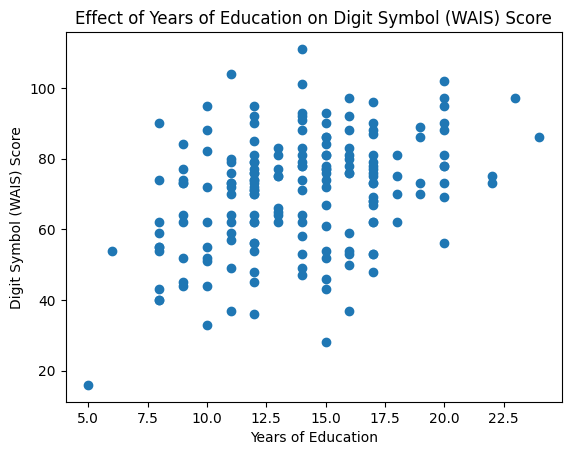

In [25]:
plt.scatter(df_features_minimal_with_yoe["educ_years"], df_features_minimal_with_yoe["digsym_wais_pga1"])
plt.xlabel("Years of Education")
plt.ylabel("Digit Symbol (WAIS) Score")
plt.title("Effect of Years of Education on Digit Symbol (WAIS) Score")

### After correction

Text(0.5, 1.0, 'Effect of Years of Education on Digit Symbol (WAIS) Score After YOE Correction')

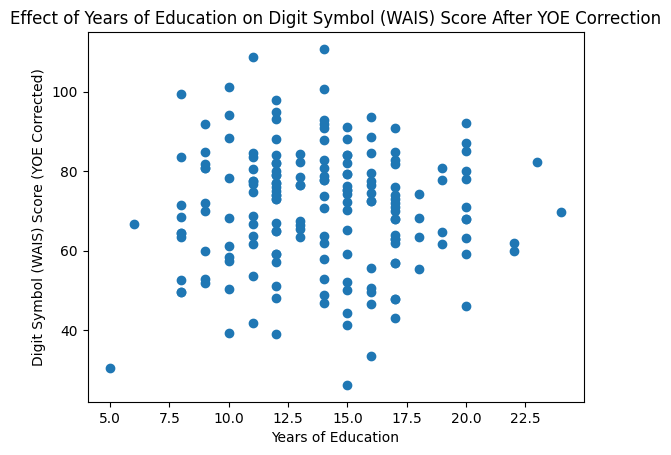

In [26]:
plt.scatter(df_features_minimal_with_yoe["educ_years"], df_features_minimal_yoe_corrected["digsym_wais_pga1_yoe_corrected"])
plt.xlabel("Years of Education")
plt.ylabel("Digit Symbol (WAIS) Score (YOE Corrected)")
plt.title("Effect of Years of Education on Digit Symbol (WAIS) Score After YOE Correction")

# FACTORS

### Load factors

## 4.1

In [27]:
# Neurological history
# Load the data, neuro history
neuro_history_name = "PGA1_MED_HISTORY_NEUROL_PHARMAMODEL.xls"
df_neuro_history = pl.read_excel(
    os.path.join(wd, neuro_history_name),
    sheet_name="GAP1_MED_HISTORY_NEUROL_PHARMAM"
)

# Variables selected by Ainara and Miren from CITA
neuro_history_vars = ["NEUROL_PRSNCE_Neu13", "CVADIS_PRSNCE_Neu13",
                       "TRBINJ_PRSNCE_Neu13", ]

# Filter the desired variables
df_neuro_history = df_neuro_history.select(["cmp_code"] + neuro_history_vars)

# Select only the participants included in the analyses
df_neuro_history = df_neuro_history.filter(pl.col("cmp_code").is_in(cmp_codes_included)).sort("cmp_code")
assert (df_neuro_history["cmp_code"] == df_features_total_pga_selected["cmp_code"]).all()

# Replace "9999" with None
df_neuro_history = df_neuro_history.select(
    pl.all().map_elements(lambda x: None if x == 9999 or x =="9999" else x)
)

# Write to csv in preprocessed data directory
save_path = os.path.join(preprocessed_data_path,
                         "supernormals_amyloid_neg_csf", "factors",
                         "neurological_history.csv")
os.makedirs(os.path.dirname(save_path), exist_ok=True)

df_neuro_history.drop("cmp_code").to_pandas().to_csv(save_path, index=True, header=True)

## 4.2

In [28]:
# Cardiovascular history
# Load the data, cardio history
cardio_history_name = "PGA1_MED_HISTORY_CARDIOVASCULAR.xlsx"
df_cardio_history = pl.read_excel(
    os.path.join(wd, cardio_history_name),
    sheet_name="Cardiovascular_history"
)
# Variables selected by Ainara and Miren from CITA
cardio_history_vars = ["CARDIO_PRSNCE_Neu12", "IHDISE_PRSNCE_Neu12"]

# Filter the desired variables
df_cardio_history = df_cardio_history.select(["cmp_code"] + cardio_history_vars)

# Select only the participants included in the analyses
df_cardio_history = df_cardio_history.filter(pl.col("cmp_code").is_in(cmp_codes_included)).sort("cmp_code")
assert (df_cardio_history["cmp_code"] == df_features_total_pga_selected["cmp_code"]).all()

# Replace "9999" with None
df_cardio_history = df_cardio_history.select(
    pl.all().map_elements(lambda x: None if x == 9999 or x =="9999" else x)
)

# Write to csv in preprocessed data directory
save_path = os.path.join(preprocessed_data_path,
                         "supernormals_amyloid_neg_csf", "factors",
                         "cardiovascular_history.csv")
os.makedirs(os.path.dirname(save_path), exist_ok=True)

df_cardio_history.drop("cmp_code").to_pandas().to_csv(save_path, index=True, header=True)

## 4.3

In [29]:
# Motor scales
motor_name = "PGA1_MOTOR_TINETTI_UPDRS-III.xls"

# Load the motor data (UPDRS-III and Tinetti)
df_motor = pl.read_excel(os.path.join(wd, motor_name),
                         sheet_name="PGA1_MOTOR_TINETTI_UPDRS-III",
                         has_header=True)

# Identify the desired variables
motor_vars = ["TINETTI_MARCHA", "TINETTI_EQUILIBRIO", "UPDRS_PUNTUACIONTOTAL"]

# Filter the desired variables and select only the participants included in the analyses
df_motor = df_motor.select(["cmp_code"] + motor_vars)
df_motor = df_motor.filter(pl.col("cmp_code").is_in(cmp_codes_included)).sort("cmp_code")
assert (df_motor["cmp_code"] == df_features_total_pga_selected["cmp_code"]).all()

# Replace "9999" with None
df_motor = df_motor.select(
    pl.all().map_elements(lambda x: None if x == 9999 or x =="9999" else x)
)

# Write to csv in preprocessed data directory
save_path = os.path.join(preprocessed_data_path,
                         "supernormals_amyloid_neg_csf", "factors",
                         "motor_scales.csv")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
df_motor.drop("cmp_code").to_pandas().to_csv(save_path, index=True, header=True)

## 4.4

In [30]:
# MFE-ADCS-ADL
mfe_adcs_adl_name = "PGA1_MFE_ADCS_ADL.xls"

# Load the MFE-ADCS-ADL data
df_mfe_adcs_adl = pl.read_excel(os.path.join(wd, mfe_adcs_adl_name),
                         sheet_name="PGA1_MFE_ADCS_ADL",
                         has_header=True)

# Identify the desired variables
mfe_adcs_adl_vars = ["P1_MFE_TotalScore", "P1_ADLAUT_SCORE9_Neu213", "P1_ADLINF_SCORE9_Neu214"]

# Filter the desired variables and select only the participants included in the analyses
df_mfe_adcs_adl = df_mfe_adcs_adl.select(["cmp_code"] + mfe_adcs_adl_vars)
df_mfe_adcs_adl = df_mfe_adcs_adl.filter(pl.col("cmp_code").is_in(cmp_codes_included)).sort("cmp_code")
assert (df_mfe_adcs_adl["cmp_code"] == df_features_total_pga_selected["cmp_code"]).all()

# Replace "9999" with None
df_mfe_adcs_adl = df_mfe_adcs_adl.select(
    pl.all().map_elements(lambda x: None if x == 9999 or x =="9999" else x)
)

# Write to csv in preprocessed data directory
save_path = os.path.join(preprocessed_data_path,
                         "supernormals_amyloid_neg_csf", "factors",
                         "mfe_adcs_adl.csv")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
df_mfe_adcs_adl.drop("cmp_code").to_pandas().to_csv(save_path, index=True, header=True)

## 4.5

In [31]:
# Neurobehavioral scales
neurobehav_symptoms = "PGA1_Neu_behavioral_symptoms_NPI_BECK_HADS_ESTRES.xls"

# Load neurobehavioral symptoms data
df_neurobehav = pl.read_excel(os.path.join(wd, neurobehav_symptoms),
                         sheet_name="PGA1_Neu_behavioral_symptoms_NP",
                         has_header=True)

# Identify the desired variables
neurobehav_vars = ["BPSHAD_HADANX_Neu207", "BPSHAD_HADEPR_Neu207",
              "BPSNPI_NPITOT_Neu209", "BPSTRS_PSQZSC_Neu210"]

# Filter the desired variables and select only the participants included in the analyses
df_neurobehav = df_neurobehav.select(["cmp_code"] + neurobehav_vars)
df_neurobehav = df_neurobehav.filter(pl.col("cmp_code").is_in(cmp_codes_included)).sort("cmp_code")
assert (df_neurobehav["cmp_code"] == df_features_total_pga_selected["cmp_code"]).all()

# Replace "9999" with None
df_neurobehav = df_neurobehav.select(
    pl.all().map_elements(lambda x: None if x == 9999 or x =="9999" else x)
)

# Write to csv in preprocessed data directory
save_path = os.path.join(preprocessed_data_path,
                         "supernormals_amyloid_neg_csf", "factors",
                         "neurobehavioral_symptoms.csv")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
df_neurobehav.drop("cmp_code").to_pandas().to_csv(save_path, index=True, header=True)

## 4.5.2

In [32]:
# Sleep scale
sleep_symptoms = "PGA1-PITTSBURGH SLEEP QUALITY INDEX_TOTAL_COMPONENTES.xls"

# Load Sleep data
df_sleep = pl.read_excel(os.path.join(wd, sleep_symptoms),
                         sheet_name="PGA1-PITTSBURGH SLEEP QUALITY I",
                         has_header=True)

# Identify the desired variables
sleep_vars = ["PSQITT_C1TTLS_Nut901", "PSQITT_C5TTLS_Nut901", "PSQITT_PSQITT_Nut901"]

# Filter the desired variables and select only the participants included in the analyses
df_sleep = df_sleep.select(["cmp_code"] + sleep_vars)
df_sleep = df_sleep.filter(pl.col("cmp_code").is_in(cmp_codes_included)).sort("cmp_code")
assert (df_sleep["cmp_code"] == df_features_total_pga_selected["cmp_code"]).all()

# Replace "9999" with None
df_sleep = df_sleep.select(
    pl.all().map_elements(lambda x: None if x == 9999 or x =="9999" else x)
)

# Write to csv in preprocessed data directory
save_path = os.path.join(preprocessed_data_path,
                         "supernormals_amyloid_neg_csf", "factors",
                         "sleep.csv")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
df_sleep.drop("cmp_code").to_pandas().to_csv(save_path, index=True, header=True)

## 5.1

In [33]:
# # vascular_metabolic scale
# vascular_metabolic_symptoms = "PGA1_VASCULAR_METABOLIC_RISK_CRITERIA.xls"

# # Load vascular_metabolic data
# df_vascular_metabolic = pl.read_excel(os.path.join(wd, vascular_metabolic_symptoms),
#                          sheet_name="PGA1_VASCULAR_METABOLIC_RISK_CR",
#                          has_header=True)

# # Identify the desired variables
# vascular_metabolic_vars = df_vascular_metabolic.columns

# # Filter the desired variables and select only the participants included in the analyses
# df_vascular_metabolic = df_vascular_metabolic.select(vascular_metabolic_vars)
# df_vascular_metabolic = df_vascular_metabolic.filter(pl.col("cmp_code").is_in(cmp_codes_included)).sort("cmp_code")
# assert (df_vascular_metabolic["cmp_code"] == df_features_total_pga_selected["cmp_code"]).all()

# # Replace "9999" with None
# df_vascular_metabolic = df_vascular_metabolic.select(
#     pl.all().map_elements(lambda x: None if x == 9999 or x =="9999" else x)
# )

# # Write to csv in preprocessed data directory
# save_path = os.path.join(preprocessed_data_path,
#                          "supernormals_amyloid_neg_csf", "factors",
#                          "vascular_metabolic.csv")
# os.makedirs(os.path.dirname(save_path), exist_ok=True)
# df_vascular_metabolic.drop("cmp_code").to_pandas().to_csv(save_path, index=True, header=True)

### 5.2

In [34]:
# vascular_parameters scale
vascular_params_name = "PGA1_VASCULAR_PARAMETERS.xlsx"

# Load vascular_parameters data
df_vascular_parameters = pl.read_excel(os.path.join(wd, vascular_params_name),
                         sheet_name="Datos",
                         has_header=True)

# Filter the desired variables and select only the participants included in the analyses
df_vascular_parameters = df_vascular_parameters.drop("P1_DMGPGA_STATUS_Dmg101")
df_vascular_parameters = df_vascular_parameters.filter(pl.col("cmp_code").is_in(cmp_codes_included)).sort("cmp_code")
assert (df_vascular_parameters["cmp_code"] == df_features_total_pga_selected["cmp_code"]).all()

# Replace "9999" with None
df_vascular_parameters = df_vascular_parameters.select(
    pl.all().map_elements(lambda x: None if x == 9999 or x =="9999" else x)
)

# Write to csv in preprocessed data directory
save_path = os.path.join(preprocessed_data_path,
                         "supernormals_amyloid_neg_csf", "factors",
                         "vascular_parameters.csv")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
df_vascular_parameters.drop("cmp_code").to_pandas().to_csv(save_path, index=True, header=True)

### 5.3

In [36]:
# vascular_metabolic scale
antropometry = "PGA1_ANTROPOMETRIA.xlsx"

# Load antropometry data
df_antropometry = pl.read_excel(os.path.join(wd, antropometry),
                         sheet_name="Datos",
                         has_header=True)

# Identify the desired variables
antropometry_vars = ["cmp_code", "P1_IMPTRY_WSTHIP_Nur101",
                     "P1_IMPTRY_BMINDX_Nur101", "P1_IMPTRY_FTFREE_Nur101",
                     "P1_IMPTRY_MSLMAS_Nur101", "P1_ANTROP_WTCH5_R_Nur101"]

# Filter the desired variables and select only the participants included in the analyses
df_antropometry = df_antropometry.select(antropometry_vars)
df_antropometry = df_antropometry.filter(pl.col("cmp_code").is_in(cmp_codes_included)).sort("cmp_code")
assert (df_antropometry["cmp_code"] == df_features_total_pga_selected["cmp_code"]).all()

# Replace "9999" with None
df_antropometry = df_antropometry.select(
    pl.all().map_elements(lambda x: None if x == 9999 or x =="9999" else x)
)

# Write to csv in preprocessed data directory
save_path = os.path.join(preprocessed_data_path,
                         "supernormals_amyloid_neg_csf", "factors",
                         "antropometry.csv")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
df_antropometry.drop("cmp_code").to_pandas().to_csv(save_path, index=True, header=True)

### 6

In [37]:
# vascular_metabolic scale
biochemistry = "PGA1_BIOQUIM_SANGRE.xlsx"

# Load biochemistry data
df_biochemistry = pl.read_excel(os.path.join(wd, biochemistry),
                         sheet_name="Datos",
                         has_header=True)

# Identify the desired variables
biochemistry_vars = ["cmp_code", "P1_LABLIP_TTCHOL_Lab101",
                     "P1_LBCLIP_HDLCHL_Lab101",
                     "P1_LABLIP_TRGLIC_Lab101",
                     "P1_LABLIP_LDLHL_Lab101",
                     "P1_LABGLU_GLUBSL_Lab101",
                     "P1_LABGLU_INSBSL_Lab101",
                     "P1_LABGLU_HBGIFC_Lab101",
                     "P1_LABGLU_HBGNGS_Lab101",
                     "P1_LABVIT_VITB12_Lab101",
                     "P1_LABVIT_FOLATE_Lab101"
]

# Filter the desired variables and select only the participants included in the analyses
df_biochemistry = df_biochemistry.select(biochemistry_vars)
df_biochemistry = df_biochemistry.filter(pl.col("cmp_code").is_in(cmp_codes_included)).sort("cmp_code")
assert (df_biochemistry["cmp_code"] == df_features_total_pga_selected["cmp_code"]).all()

# Replace "9999" with None
df_biochemistry = df_biochemistry.select(
    pl.all().map_elements(lambda x: None if x == 9999 or x =="9999" else x)
)

# Write to csv in preprocessed data directory
save_path = os.path.join(preprocessed_data_path,
                         "supernormals_amyloid_neg_csf", "factors",
                         "biochemistry.csv")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
df_biochemistry.drop("cmp_code").to_pandas().to_csv(save_path, index=True, header=True)

### 7.1

In [38]:
# vascular_metabolic scale
cognitive_reserve = "PGA1_RESERVA_COGNITIVA.xlsx"

# Load cognitive reserve data
df_cognitive_reserve = pl.read_excel(os.path.join(wd, cognitive_reserve),
                         sheet_name="Datos",
                         has_header=True)

# Identify the desired variables
cognitive_reserve_vars = ["cmp_code", "P1_DMGISP_ISPTOT_Dmg101",
                           "CRC_Total",
                           "P1_CUEST_OCIO_PRODUCTIVAS_TOTAL",
                           "P1_VOCBWS_TTLZSC_Nps102",
                           "P1_BILINGUISMO",
                           "P1_EARLY_LATE_MONOL",
                           "P1_EARLY_LATE_PUREMON"
]

# Filter the desired variables and select only the participants included in the analyses
df_cognitive_reserve = df_cognitive_reserve.select(cognitive_reserve_vars)
df_cognitive_reserve = df_cognitive_reserve.filter(pl.col("cmp_code").is_in(cmp_codes_included)).sort("cmp_code")
assert (df_cognitive_reserve["cmp_code"] == df_features_total_pga_selected["cmp_code"]).all()

# Replace "9999" with None
df_cognitive_reserve = df_cognitive_reserve.select(
    pl.all().map_elements(lambda x: None if x == 9999 or x =="9999" else x)
)

# Write to csv in preprocessed data directory
save_path = os.path.join(preprocessed_data_path,
                         "supernormals_amyloid_neg_csf", "factors",
                         "cognitive_reserve.csv")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
df_cognitive_reserve.drop("cmp_code").to_pandas().to_csv(save_path, index=True, header=True)

### 7.2

In [39]:
# vascular_metabolic scale
tobacco = "PGA1_TOBACCO_Type_Numcig_smkyears_paxyear.xls"

# Load cognitive reserve data
df_tobacco = pl.read_excel(os.path.join(wd, tobacco),
                         sheet_name="PGA1_TOBACCO_Type_Numcig_smkyea",
                         has_header=True)

# Identify the desired variables
tobacco_vars = df_tobacco.columns
# Filter the desired variables and select only the participants included in the analyses
df_tobacco = df_tobacco.select(tobacco_vars)
df_tobacco = df_tobacco.filter(pl.col("cmp_code").is_in(cmp_codes_included)).sort("cmp_code")
assert (df_tobacco["cmp_code"] == df_features_total_pga_selected["cmp_code"]).all()

# Replace "9999" with None
df_tobacco = df_tobacco.select(
    pl.all().map_elements(lambda x: None if x == 9999 or x =="9999" else x)
)

# Write to csv in preprocessed data directory
save_path = os.path.join(preprocessed_data_path,
                         "supernormals_amyloid_neg_csf", "factors",
                         "tobacco.csv")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
df_tobacco.drop("cmp_code").to_pandas().to_csv(save_path, index=True, header=True)

### 7.3

In [40]:
# vascular_metabolic scale
alcohol = "PGA1-ALCOHOL_Total_present_past.xls"

# Load cognitive reserve data
df_alcohol = pl.read_excel(os.path.join(wd, alcohol),
                         sheet_name="PGA1-ALCOHOL_Total_actualidad_p",
                         has_header=True)

# Identify the desired variables
alcohol_vars = df_alcohol.columns
# Filter the desired variables and select only the participants included in the analyses
df_alcohol = df_alcohol.select(alcohol_vars)
df_alcohol = df_alcohol.filter(pl.col("cmp_code").is_in(cmp_codes_included)).sort("cmp_code")
assert (df_alcohol["cmp_code"] == df_features_total_pga_selected["cmp_code"]).all()

# Replace "9999" with None
df_alcohol = df_alcohol.select(
    pl.all().map_elements(lambda x: None if x == 9999 or x =="9999" else x)
)

# Write to csv in preprocessed data directory
save_path = os.path.join(preprocessed_data_path,
                         "supernormals_amyloid_neg_csf", "factors",
                         "alcohol.csv")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
df_alcohol.drop("cmp_code").to_pandas().to_csv(save_path, index=True, header=True)

### 7.4

In [41]:
# vascular_metabolic scale
diet = "PGA1_MEDITERRANEAN_DIET_MEDAS.xls"

# Load cognitive reserve data
df_diet = pl.read_excel(os.path.join(wd, diet),
                         sheet_name="MEDITERRANEAN_DIET_MEDAS",
                         has_header=True)

# Identify the desired variables
diet_vars = df_diet.columns
# Filter the desired variables and select only the participants included in the analyses
df_diet = df_diet.select(diet_vars)
df_diet = df_diet.filter(pl.col("cmp_code").is_in(cmp_codes_included)).sort("cmp_code")
assert (df_diet["cmp_code"] == df_features_total_pga_selected["cmp_code"]).all()

# Replace "9999" with None
df_diet = df_diet.select(
    pl.all().map_elements(lambda x: None if x == 9999 or x =="9999" else x)
)

# Write to csv in preprocessed data directory
save_path = os.path.join(preprocessed_data_path,
                         "supernormals_amyloid_neg_csf", "factors",
                         "diet.csv")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
df_diet.drop("cmp_code").to_pandas().to_csv(save_path, index=True, header=True)

### 7.5

In [44]:
# ipaq
ipaq = "PGA1_ACTIVIDAD_FÍSICA.xlsx"

# Load cognitive reserve data
df_ipaq = pl.read_excel(os.path.join(wd, ipaq),
                         sheet_name="Datos",
                         has_header=True)
# Identify the desired variables
ipaq_vars = ["cmp_code", "P1_IPAQMH_PATOTL_Nut701",
             ]

# Load the sitting data
sitting = "PGA1_NUT801-SEDENTARISM.xlsx"
df_sedentarism = pl.read_excel(os.path.join(wd, sitting),
                         sheet_name="PGA1_NUT801-SEDENTARISM",
                         has_header=True)

# Identify the desired variables
sedentarism_vars = ["cmp_code", "SDNTMF_CMPUTR_Nut801", "SDNTMF_DRIVNG_Nut801",
                    "SDNTSS_CMPUTR_Nut801", "SDNTSS_DRIVNG_Nut801",
                    "SDNTTT_SITTOT_Nut801"]

# Join the sitting time with the ipaq data
df_ipaq_sitting = df_ipaq.join(df_sedentarism.select(sedentarism_vars),
                               on="cmp_code", how="left")

# Filter the desired variables and select only the participants included in the analyses
df_ipaq_sitting = df_ipaq_sitting.filter(pl.col("cmp_code").is_in(cmp_codes_included)).sort("cmp_code")
assert (df_ipaq_sitting["cmp_code"] == df_features_total_pga_selected["cmp_code"]).all()

# Replace "9999" with None
df_ipaq_sitting = df_ipaq_sitting.select(
    pl.all().map_elements(lambda x: None if x == 9999 or x =="9999" else x)
)

# Write to csv in preprocessed data directory
save_path = os.path.join(preprocessed_data_path,
                         "supernormals_amyloid_neg_csf", "factors",
                         "ipaq_sitting.csv")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
df_ipaq_sitting.drop("cmp_code").to_pandas().to_csv(save_path, index=True, header=True)

### Save factors

In [ ]:
# df_factors.to_pandas().drop("cmp_code", axis=1).to_csv("./preprocessed_data/factors.csv", index=True, header=True)